In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.metrics import classification_report

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

import operator
from functools import reduce

import eli5

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train_data.txt',delimiter='\t',header=None,skip_blank_lines=False)
df_dev = pd.read_csv('dev_data.txt',delimiter='\t',header=None,skip_blank_lines=False)
df_test = pd.read_csv('test_data.txt',delimiter='\t',header=None,skip_blank_lines=False)
df_train.columns=['entity','IOB_label']
df_dev.columns=['entity','IOB_label']
df_test.columns=['entity']

In [3]:
print('# of sentences(np.nan): ')
print('train data: ',df_train.isnull().sum())
print('dev data: ',df_dev.isnull().sum())
print('test data: ',df_test.isnull().sum())
print('train data: ',df_train.describe())
print('dev data: ',df_dev.describe())
print('test data: ',df_dev.describe())
print('labels: ',df_train.groupby('IOB_label').size().reset_index(name='counts'))

y_labels = df_train.dropna(axis=0,how='all')['IOB_label'].values
classes = np.unique(y_labels)
classes = classes.tolist()
# due to the large number of 
new_classes = classes.copy()
new_classes.pop()

# of sentences(np.nan): 
train data:  entity       1969
IOB_label    1969
dtype: int64
dev data:  entity       915
IOB_label    909
dtype: int64
test data:  entity    4270
dtype: int64
train data:         entity IOB_label
count   37619     37619
unique   9202        15
top         .         O
freq     1221     35679
dev data:         entity IOB_label
count   14395     14401
unique   5689        15
top         :         O
freq      397     13441
test data:         entity IOB_label
count   14395     14401
unique   5689        15
top         :         O
freq      397     13441
labels:       IOB_label  counts
0    B-company     144
1      B-group      85
2   B-location     316
3      B-other     177
4     B-person     361
5    B-product      74
6      B-title      51
7    I-company      31
8      I-group      63
9   I-location     124
10     I-other     230
11    I-person     168
12   I-product      61
13     I-title      55
14           O   35679


'O'

## Initialize sentence # column with np.nan

In [4]:
df_train['sentences #'] = np.nan
df_dev['sentences #'] = np.nan
df_test['sentences #'] = np.nan

## Find the range of each sentence and fill the sentence # column

In [5]:
def Find_sentence_loc(df):
    
    sentence_loc = df[df.isnull().T.all()]
    sentence_loc.reset_index(inplace=True)
    return sentence_loc

s_train = Find_sentence_loc(df_train)
s_dev = Find_sentence_loc(df_dev)
s_test = Find_sentence_loc(df_test)

def Mark_each_stns(df,sentence_loc):
    j = 0
    for i in range(len(df)):
        if i < sentence_loc['index'][j]:
            df['sentences #'][i] = str(j+1)
        else:
            j = j+1
    df.dropna(axis=0,inplace=True,how='any')
    df.reset_index(drop=True,inplace=True)
    return df

df_train = Mark_each_stns(df_train,s_train)
df_dev = Mark_each_stns(df_dev,s_dev)
df_test = Mark_each_stns(df_test,s_test)

In [6]:
df_train.head(20)

,entity,IOB_label,sentences #
0,@SammieLynnsMom,O,1.0
1,@tg10781,O,1.0
2,they,O,1.0
3,will,O,1.0
4,be,O,1.0
5,all,O,1.0
6,done,O,1.0
7,by,O,1.0
8,Sunday,O,1.0
9,trust,O,1.0


## Get sentences from words (dataset is given by each word, separated by blank line)

In [7]:
class SentenceGetter_group(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(e,t,b,p,l) for e,t,b,p,l in zip(s['entity'].values.tolist(), 
                                                           s['POS_t'].values.tolist(),
                                                           s['POS_b'].values.tolist(),
                                                           s['POS_p'].values.tolist(),
                                                           s['IOB_label'].values.tolist())]
        self.grouped = self.data.groupby('sentences #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
        
class SentenceGetter_group_test(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(e,t,b,p) for e,t,b,p in zip(s['entity'].values.tolist(),
                                                           s['POS_t'].values.tolist(),
                                                           s['POS_b'].values.tolist(),
                                                           s['POS_p'].values.tolist())]
        self.grouped = self.data.groupby('sentences #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None        
        
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w) for w in zip(s['entity'].values.tolist())]
        self.grouped = self.data.groupby('sentences #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
        
getter_train = SentenceGetter(df_train)
sentences_train = getter_train.sentences
getter_dev = SentenceGetter(df_dev)
sentences_dev = getter_dev.sentences
getter_test = SentenceGetter(df_test)
sentences_test = getter_test.sentences

## Add pos tagging

In [8]:
import nltk
from nltk import word_tokenize
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk import pos_tag
from nltk.corpus import stopwords

import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')

import inflection

def is_camel_case_f(s):
    return inflection.camelize(s, uppercase_first_letter=False) == s
def is_camel_case_l(s):
    return inflection.camelize(s, uppercase_first_letter=True) == s

In [9]:
b_train_sents  = brown.tagged_sents()
t_train_sents  = treebank.tagged_sents()

english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%',"'",'"']
stops = set(stopwords.words("english"))

b0 = nltk.DefaultTagger('NN')
b1 = nltk.UnigramTagger(b_train_sents, backoff=b0)
b2 = nltk.BigramTagger(b_train_sents, backoff=b1)
t1 = nltk.UnigramTagger(t_train_sents, backoff=b0)
t2 = nltk.BigramTagger(t_train_sents, backoff=t1)
p2 = pos_tag

In [10]:
df_train['POS_p'] = np.nan
df_dev['POS_p'] = np.nan
df_test['POS_p'] = np.nan
df_train['POS_b'] = np.nan
df_dev['POS_b'] = np.nan
df_test['POS_b'] = np.nan
df_train['POS_t'] = np.nan
df_dev['POS_t'] = np.nan
df_test['POS_t'] = np.nan

In [11]:
def Convert(lst): 
    res_dct = {i[0]: i[1] for i in lst} 
    return res_dct

In [12]:
def Add_pos_tag(df,sentences,crps,colm=None):

    for sts_num in range(len(sentences)):
        loc = df[df['sentences #']==sts_num+1].index.to_list()

        stns = " ".join([w[0] for w in sentences[sts_num]])
        text = word_tokenize(stns)
        text= [word for word in text if word not in english_punctuations]
        ts = crps(text)
        tag = [t[1] for t in ts]
        d_ts = Convert(ts)
        if len(tag)==len(loc):
            df[colm][loc]=tag
        else:
            for i in loc:
                if df['entity'][i] in d_ts.keys():
                    df[colm][i]=d_ts[df['entity'][i]]
                else:
                    df[colm][i]=df['entity'][i]
    return df

In [13]:
df_train = Add_pos_tag(df_train,sentences_train,b2.tag,'POS_b')
df_dev = Add_pos_tag(df_dev,sentences_dev,b2.tag,'POS_b')
df_test = Add_pos_tag(df_test,sentences_test,b2.tag,'POS_b')
df_train = Add_pos_tag(df_train,sentences_train,t2.tag,'POS_t')
df_dev = Add_pos_tag(df_dev,sentences_dev,t2.tag,'POS_t')
df_test = Add_pos_tag(df_test,sentences_test,t2.tag,'POS_t')
df_train = Add_pos_tag(df_train,sentences_train,p2,'POS_p')
df_dev = Add_pos_tag(df_dev,sentences_dev,p2,'POS_p')
df_test = Add_pos_tag(df_test,sentences_test,p2,'POS_p')

In [14]:
df_train.tail()

,entity,IOB_label,sentences #,POS_p,POS_b,POS_t
37614,whatchu,O,1969.0,NNS,NN,NN
37615,got,O,1969.0,VBD,VBD,VBD
37616,for,O,1969.0,IN,IN,IN
37617,me,O,1969.0,PRP,PPO,PRP
37618,@kanyewest,O,1969.0,JJS,NN,NN


## Feature extraction

In [73]:
def Features_repeat(sent,features,i,num):
    
    if i > num-1:
        word1 = sent[i-num][0]
        treetag1 = sent[i-num][1]
        browntag1 = sent[i-num][2]        
        postag1 = sent[i-num][3]

        sword1 = nlp(word1)

        if len(sword1.ents)!= 0:
            label_ = sword1.ents[0].label_
            s_char = sword1.ents[0].start_char
            e_char = sword1.ents[0].end_char
        else:
            label_ = 'NN'
            s_char = 0
            e_char = 0 


        features.update({
            str(num-2)+'word.length()': len(word1),
            str(num-2)+':word.isalpha':sword1[0].is_alpha,
            str(num-2)+':word.ispunct':sword1[0].is_punct,
            #str(num-2)+':word.isspace':sword1[0].is_space,
            str(num-2)+':word.is_stop':sword1[0].is_stop,
            str(num-2)+':word.shape_':sword1[0].shape_,
            str(num-2)+':word.lemma_':sword1[0].lemma_,
            str(num-2)+':word.pos_':sword1[0].pos_,
            str(num-2)+':word.tag_':sword1[0].tag_,

            str(num-2)+':word.isent':len(sword1.ents)!= 0,
            str(num-2)+':word.label_': label_,
            str(num-2)+':word.start_char': s_char,
            str(num-2)+':word.end_char': e_char,

            str(num-2)+':word.lower()': word1.lower(),
            str(num-2)+':word[0:2]': word1[0:2],
            str(num-2)+':word[0:3]': word1[0:3],        
            str(num-2)+':word[-3:]': word1[-3:],
            str(num-2)+':word[-2:]': word1[-2:],  
            str(num-2)+':word.iscamelcasel()': is_camel_case_l(word1),
            str(num-2)+':word.iscamelcasef()': is_camel_case_f(word1),
            str(num-2)+':word.istitle()': word1.istitle(),
            str(num-2)+':word.isupper()': word1.isupper(),              
            str(num-2)+':treetag': treetag1,
            str(num-2)+':treetag[:2]': treetag1[:2],
            str(num-2)+':browntag': browntag1,
            str(num-2)+':browntag[:2]': browntag1[:2],
            str(num-2)+':postag': postag1,
            str(num-2)+':postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-num:
        word1 = sent[i+num][0]
        treetag1 = sent[i+num][1]
        browntag1 = sent[i+num][2] 
        postag1 = sent[i+num][3]
        
        sword1 = nlp(word1)

        if len(nlp(word1).ents)!= 0:
            label_ = sword1.ents[0].label_
            s_char = sword1.ents[0].start_char
            e_char = sword1.ents[0].end_char
        else:
            label_ = 'NN'
            s_char = 0
            e_char = 0   
    
        features.update({
            '+'+str(num)+'word.length()': len(word1),
            '+'+str(num)+':word.isalpha':sword1[0].is_alpha,
            '+'+str(num)+':word.ispunct':sword1[0].is_punct,
            #'+'+str(num)+':word.isspace':sword1[0].is_space,
            '+'+str(num)+':word.is_stop':sword1[0].is_stop,
            '+'+str(num)+':word.shape_':sword1[0].shape_,
            '+'+str(num)+':word.lemma_':sword1[0].lemma_,
            '+'+str(num)+':word.pos_':sword1[0].pos_,
            '+'+str(num)+':word.tag_':sword1[0].tag_,
            
            '+'+str(num)+':word.isent':len(sword1.ents)!= 0,
            '+'+str(num)+':word.label_': label_,
            '+'+str(num)+':word.start_char': s_char,
            '+'+str(num)+':word.end_char': e_char,
            
            '+'+str(num)+':word[0:2]': word1[0:2],
            '+'+str(num)+':word[0:3]': word1[0:3],        
            '+'+str(num)+':word[-3:]': word1[-3:],
            '+'+str(num)+':word[-2:]': word1[-2:],
            '+'+str(num)+':word.iscamelcasel()': is_camel_case_l(word1),
            '+'+str(num)+':word.iscamelcasef()': is_camel_case_f(word1),
            '+'+str(num)+':word.lower()': word1.lower(),
            '+'+str(num)+':word.istitle()': word1.istitle(),
            '+'+str(num)+':word.isupper()': word1.isupper(),
            '+'+str(num)+'::treetag': treetag1,
            '+'+str(num)+':treetag[:2]': treetag1[:2],
            '+'+str(num)+':browntag': browntag1,
            '+'+str(num)+'::browntag[:2]': browntag1[:2],
            '+'+str(num)+':postag': postag1,
            '+'+str(num)+':postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

In [74]:
def word2features(sent, i):
    word = sent[i][0]
    treetag = sent[i][1]
    browntag = sent[i][2]
    postag = sent[i][3]
    
    sword = nlp(word)

    if len(nlp(word).ents)!= 0:
        label_ = sword.ents[0].label_
        s_char = sword.ents[0].start_char
        e_char = sword.ents[0].end_char
    else:
        label_ = 'NN'
        s_char = 0
        e_char = 0      

    features = {
        'bias': 1.0,
        'word.length()': len(word),
        
        # POS tagging spacy
        'word.isalpha':sword[0].is_alpha,
        'word.ispunct':sword[0].is_punct,
        #'word.isspace':sword[0].is_space,
        'word.is_stop':sword[0].is_stop,
        'word.shape_':sword[0].shape_,
        'word.lemma_':sword[0].lemma_,
        'word.dep_':sword[0].dep_
        'word.pos_':nlp(word)[0].pos_,
        'word.tag_':nlp(word)[0].tag_,
        
        'word.isent':len(sword.ents)!= 0,
        'word.label_': label_,
        'word.start_char': s_char,
        'word.end_char': e_char,
        
        #
        'word.lower()': word.lower(),
        'word[0:2]': word[0:2],
        'word[0:3]': word[0:3],        
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.iscamelcasel()': is_camel_case_l(word),
        'word.iscamelcasef()': is_camel_case_f(word),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        ## pos tags
        'treetag': treetag,
        'treetag[:2]': treetag[:2],
        'browntag': browntag,
        'browntag[:2]': browntag[:2],
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    features = Features_repeat(sent,features,i,1)    
    #features = Features_repeat(sent,features,i,2)
    #features = Features_repeat(sent,features,i,3)
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, treetag, browntag, postag, label in sent]

def sent2tokens(sent):
    return [token for token, treetag, browntag, postag, label in sent]

In [17]:
getter_train_g = SentenceGetter_group(df_train)
sentences_train_g = getter_train_g.sentences
getter_dev_g = SentenceGetter_group(df_dev)
sentences_dev_g = getter_dev_g.sentences
getter_test_g = SentenceGetter_group_test(df_test)
sentences_test_g = getter_test_g.sentences

In [76]:
X_train = []
for i in range(len(sentences_train_g)):
    X_train.append(sent2features(sentences_train_g[i]))
y_train = []
for i in range(len(sentences_train_g)):
    y_train.append(sent2labels(sentences_train_g[i]))
X_dev = []
for i in range(len(sentences_dev_g)):
    X_dev.append(sent2features(sentences_dev_g[i]))
y_dev = []
for i in range(len(sentences_dev_g)):
    y_dev.append(sent2labels(sentences_dev_g[i]))
X_test = []
for i in range(len(sentences_test_g)):
    X_test.append(sent2features(sentences_test_g[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968


In [83]:
X_train[0]

[{'bias': 1.0,
  'word.isalpha': False,
  'word.ispunct': False,
  'word.is_stop': False,
  'word.shape_': '@XxxxxXxxxxXxx',
  'word.lemma_': '@sammielynnsmom',
  'word.isent': False,
  'word.label_': 'NN',
  'word.start_char': 0,
  'word.end_char': 0,
  'word.lower()': '@sammielynnsmom',
  'word[0:2]': '@S',
  'word[0:3]': '@Sa',
  'word[-3:]': 'Mom',
  'word[-2:]': 'om',
  'word.iscamelcasel()': True,
  'word.iscamelcasef()': True,
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'treetag': 'NN',
  'treetag[:2]': 'NN',
  'browntag': 'NN',
  'browntag[:2]': 'NN',
  'postag': 'NNP',
  'postag[:2]': 'NN',
  'BOS': True,
  '+1:word.isalpha': False,
  '+1:word.ispunct': False,
  '+1:word.is_stop': False,
  '+1:word.shape_': '@xxdddd',
  '+1:word.lemma_': '@tg10781',
  '+1:word.isent': False,
  '+1:word.label_': 'NN',
  '+1:word.start_char': 0,
  '+1:word.end_char': 0,
  '+1:word[0:2]': '@t',
  '+1:word[-3:]': '781',
  '+1:word.lower()': '@tg10781',
  '+1:

## train CRF model

In [77]:
crf1 = sklearn_crfsuite.CRF(algorithm='lbfgs',c1=0.10416017354132473,c2=0.00012194869009786341,max_iterations=200,all_possible_transitions=True)
crf1.fit(X_train, y_train, X_dev,y_dev)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.10416017354132473, c2=0.00012194869009786341,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=200,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## test performance

In [78]:
y_pred = crf1.predict(X_dev)

In [79]:
print('accuracy score: ',metrics.flat_accuracy_score(y_dev, y_pred))
print('F1 score: ',metrics.flat_f1_score(y_dev, y_pred, average='weighted', labels=new_classes))
sorted_labels = sorted(new_classes,key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_dev, y_pred, labels=sorted_labels, digits=3))

accuracy score:  0.937269885376867
F1 score:  0.2880129719988201
              precision    recall  f1-score   support

   B-company      0.467     0.206     0.286        34
   I-company      0.000     0.000     0.000         8
     B-group      0.154     0.020     0.035       100
     I-group      0.000     0.000     0.000        43
  B-location      0.579     0.482     0.526       137
  I-location      0.462     0.333     0.387        72
     B-other      0.300     0.149     0.199       121
     I-other      0.108     0.267     0.153        75
    B-person      0.562     0.490     0.524       147
    I-person      0.570     0.613     0.590        80
   B-product      0.500     0.062     0.111        32
   I-product      0.000     0.000     0.000        88
     B-title      0.000     0.000     0.000        10
     I-title      0.000     0.000     0.000        13

   micro avg      0.377     0.271     0.315       960
   macro avg      0.264     0.187     0.201       960
weighted avg   

## prediction 

In [84]:
y_prediction = crf.predict(X_test)
print('# of sentences prediction: ',len(y_prediction))
df_test['IBO_label'] = reduce(operator.add, y_prediction)
print('# of entity prediction: ', len(df_test))

# of sentences prediction:  4270
# of entity prediction:  42413


In [85]:
f_write = open('test prediction 2.txt', 'w',encoding="utf-8")
last_sent = 0
for sent_i in range(len(y_prediction)):
    length = len(y_prediction[sent_i])
    next_sent = last_sent+length
    for i in range(last_sent,next_sent):
        row = ' '.join(map(str, df_test.drop(['sentences #','POS_p','POS_t','POS_b'],axis=1).iloc[i].values))
        f_write.writelines(row)
        f_write.write('\n')
    f_write.write('\n')
    last_sent = next_sent
f_write.close()

In [ ]:
df_test.head()

In [ ]:
df_test.to_csv('test prediction 1.txt',sep=' ',columns=['entity','IBO_label'],header=False,index=False)

In [ ]:
#eli5.show_weights(crf, top=10)

## fine tune hyperparameters

In [80]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',max_iterations=200,all_possible_transitions=True)
params_space = {'c1': scipy.stats.expon(scale=0.5),'c2': scipy.stats.expon(scale=0.05)}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=new_classes)

# search
rs = RandomizedSearchCV(crf, params_space,cv=3,verbose=1,n_jobs=-1,n_iter=50,scoring=f1_scorer)
rs.fit(X_train,y_train,X_dev=X_dev, y_dev=y_dev)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 36.0min finished


Wall time: 36min 37s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000252598FC320>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighte

In [81]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
#print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.05888949085127037, 'c2': 0.04984004344685036}
best CV score: 0.42564044011068036


In [93]:
rs.cv_results_['mean_test_score']

array([0.40311565, 0.38297492, 0.40468285, 0.4158946 , 0.41585853,
       0.42564044, 0.40716077, 0.42307175, 0.39704247, 0.39169404,
       0.40027799, 0.41527693, 0.42474533, 0.4056927 , 0.40408094,
       0.40622994, 0.36700824, 0.36132572, 0.42410664, 0.40274847,
       0.39344651, 0.41243526, 0.42091412, 0.39565489, 0.41349013,
       0.41190724, 0.42397601, 0.38598333, 0.37519446, 0.3985666 ,
       0.39698327, 0.41187986, 0.41667427, 0.38147677, 0.38687656,
       0.40744804, 0.40303348, 0.38313748, 0.41115005, 0.41713817,
       0.38174098, 0.41004804, 0.37798226, 0.39569152, 0.39701854,
       0.40352237, 0.39595319, 0.3981211 , 0.36651267, 0.42025265])

## check parameter space

Dark blue => 0.3613, dark red => 0.4256


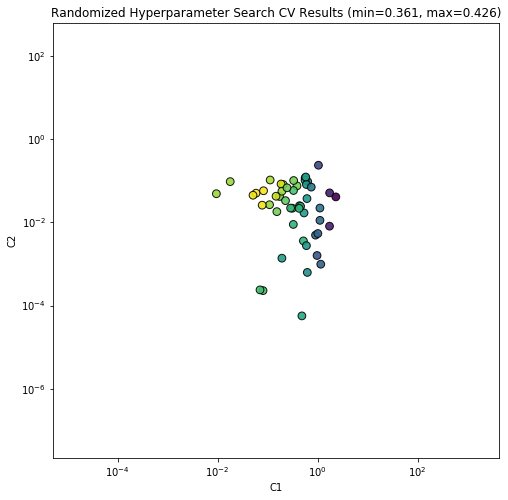

In [91]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = rs.cv_results_['mean_test_score']

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
fig.savefig('search parameter.png', dpi=300)
print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## chech the best model

In [82]:
crf = rs.best_estimator_
y_pred = crf.predict(X_dev)
print('accuracy score: ',metrics.flat_accuracy_score(y_dev, y_pred))
print('F1 score: ',metrics.flat_f1_score(y_dev, y_pred,average='weighted', labels=new_classes))
sorted_labels = sorted(new_classes,key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_dev, y_pred, labels=sorted_labels, digits=3))

accuracy score:  0.9405349079541507
F1 score:  0.29561745674383
              precision    recall  f1-score   support

   B-company      0.636     0.206     0.311        34
   I-company      0.000     0.000     0.000         8
     B-group      0.417     0.050     0.089       100
     I-group      0.100     0.023     0.038        43
  B-location      0.602     0.474     0.531       137
  I-location      0.439     0.250     0.319        72
     B-other      0.265     0.107     0.153       121
     I-other      0.097     0.200     0.130        75
    B-person      0.603     0.497     0.545       147
    I-person      0.646     0.637     0.642        80
   B-product      0.500     0.062     0.111        32
   I-product      0.400     0.023     0.043        88
     B-title      0.000     0.000     0.000        10
     I-title      0.000     0.000     0.000        13

   micro avg      0.416     0.263     0.322       960
   macro avg      0.336     0.181     0.208       960
weighted avg    

## check what the CRF learned

In [123]:
crf.attributes_

AttributeError: 'NoneType' object has no attribute 'group'

In [114]:
crf.transition_features_

AttributeError: 'NoneType' object has no attribute 'group'

In [116]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:


AttributeError: 'NoneType' object has no attribute 'group'

In [102]:
eli5.show_weights(crf, top=10)

AttributeError: 'NoneType' object has no attribute 'group'